# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Tfg21DB/code/codigoDefinitivo/
%ls

/content/drive/.shortcut-targets-by-id/1waXts2wWolJlTC42glof2iojMm2ijYsx/Tfg21DB/code/codigoDefinitivo
 sp500_data.csv   sp500_data.gsheet  'StockBSHprediction (1).ipynb'


In [ ]:
%%capture
from datetime import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import requests
import io
from datetime import datetime as date
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style
import seaborn as sns
from xgboost import XGBClassifier
import sklearn as sk
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import json
import random
!pip install pypi-install
!pip install mplfinance
!pip install tqdm
import mplfinance as mplf
import warnings
from mplfinance.original_flavor import candlestick_ohlc
from bs4 import BeautifulSoup
from collections import Counter
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from collections import Counter
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from os.path import exists

In [ ]:
style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 10]

In [ ]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

#Auxiliary functions

In [ ]:
def print_accuracy(model, X_train, X_test, y_train, y_test):
  print("========================================")
  y_train_preds = model.predict(X_train)
  acc_train = accuracy_score(y_train, y_train_preds) * 100
  y_test_preds = model.predict(X_test)
  acc_test = accuracy_score(y_test, y_test_preds) * 100
  print(f"Train accuracy: {acc_train} %")
  print(f"Test accuracy: {acc_test} %")
  print("========================================")
  return y_test_preds

In [ ]:
def print_precision(model, X_train, X_test, y_train, y_test):
  print("========================================")
  y_train_preds = model.predict(X_train)
  acc_train = precision_score(y_train, y_train_preds) * 100
  y_test_preds = model.predict(X_test)
  acc_test = precision_score(y_test, y_test_preds) * 100
  print(f"Train precision: {acc_train} %")
  print(f"Test precision: {acc_test} %")
  print("========================================")
  return y_test_preds

In [ ]:
def get_sp500_stocks():
  table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
  df = table[0]
  return df['Symbol']

In [ ]:
def clean_sp500_stocks():
  stocks = []
  for stock in get_sp500_stocks():
    if stock == 'BF.B':
      stocks.append("BF-B")
    elif stock == 'BRK.B':
      stocks.append("BRK-B")
    else:
      stocks.append(stock)
  return stocks

In [ ]:
def fetch_yahoo(stock_symbol):
  headers = {
      'User-Agent': 'Mozilla/5.0'
  }
  url = "https://query1.finance.yahoo.com/v7/finance/download/"
  url += str(stock_symbol)
  url += "?period1=1030060800&period2=1661212800&interval=1d&events=history&includeAdjustedClose=true"
  r = requests.get(url, headers=headers)
  pds = pd.read_csv(io.StringIO(r.text), index_col=0, parse_dates=True)
  return pds

In [ ]:
def fetch_ratio(ratio, stock_symbol, v_i, trailing=False, debug=False):
  statements = {'v1': 'balance-sheet', 'v2': 'income-statement', 'v3': 'price-ratios'}
  data = []
  statement = statements[v_i]
  if trailing == True:
     #find ratio in the table and choose statement accordingly
     if ratio in v1_ratios:
       statement = 'balance-sheet'
     if ratio in v2_ratios:
       statement = 'income-statement'
     else:
       statement = 'price-ratios'
  url = f"https://www.macrotrends.net/assets/php/fundamental_iframe.php?t={stock_symbol}&type={ratio}&statement={statement}&freq=Q"
  if ratio == 'profit-margins':
      url = f"https://www.macrotrends.net/assets/php/fundamental_metric.php?t={stock_symbol}&chart=profit-margin"
  html_doc = requests.get(url).text
  if debug == True: print(url)
  res = re.search(r"chartData = (\[\{.*?\}\])", html_doc)
  if res is None:
    return None
  res = res.group(1)
  res = json.loads(res)
  for entry in res:
    data.append((entry['date'], stock_symbol, entry[v_i]))

  if trailing == True:
    ratio = ratio + "_12M"
  return pd.DataFrame(data, columns=['Date', 'Ticker', ratio])

In [ ]:
v3_ratios = ['pe-ratio', 
          'price-sales', 
          'price-book', 
          'price-fcf', 
          'current-ratio', 
          'quick-ratio', 
          'debt-equity-ratio', 
          'roe', 'roa', 
          'return-on-tangible-equity', 
          'ebitda-margin',
          'operating-margin']
trailing_ratios = ['eps-earnings-per-share-diluted',
                   'operating-income',
                   'ebitda',
                   'gross-profit',
                   ''
]
v1_ratios = ['total-assets',
             'total-liabilities',
             'total-share-holder-equity',
             'long-term-debt',
             'shares-outstanding',
]

v2_ratios = [
          'eps-earnings-per-share-diluted',
          'net-profit-margin',
          'net-income',
          'ebitda',
          'operating-income',
          'gross-profit',
          'profit-margins',
          'eps-basic-net-earnings-per-share',
]

In [ ]:
def fetch_ratios(stock_symbol, debug=False):
  df = pd.DataFrame()
  for ratio in v1_ratios:
    if debug == True: print(f"fetching {ratio} for {stock_symbol}")
    df_ratio = fetch_ratio(ratio, stock_symbol, 'v1', debug=debug)
    if df_ratio is not None:
      if df.empty:
        df = df_ratio
      else:
        df = pd.merge(df, df_ratio)
  for ratio in v2_ratios:
    if debug == True: print(f"fetching {ratio} for {stock_symbol}")
    df_ratio = fetch_ratio(ratio, stock_symbol, 'v2', debug=debug)
    if df_ratio is not None:
      df = pd.merge(df, df_ratio)
  for ratio in v3_ratios:
    if debug == True: print(f"fetching {ratio} for {stock_symbol}")
    df_ratio = fetch_ratio(ratio, stock_symbol, 'v3', debug=debug)
    if df_ratio is not None:
      df = pd.merge(df, df_ratio)
  for ratio in trailing_ratios:
    if debug == True: print(f"fetching {ratio} for {stock_symbol}")
    df_ratio = fetch_ratio(ratio, stock_symbol, 'v1', True, debug=debug)
    if df_ratio is not None:    
      df = pd.merge(df, df_ratio)
  return df

In [ ]:
def fetch_dataframes(stock_symbol):
  if stock_symbol == 'BF.B':
    df_prices = fetch_yahoo("BF-B")
  elif stock_symbol == 'BRK.B':
    df_prices = fetch_yahoo("BRK-B")
  else:
    df_prices = fetch_yahoo(stock_symbol)
  df_ratios = fetch_ratios(stock_symbol)
  df_ratios.set_index('Date', inplace=True)
  df_prices.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
  start_date = str(df_prices.index[0])
  end_date = str(df_prices.index[-1])
  idx = pd.date_range(start_date, end_date)
  df_prices = df_prices.reindex(idx)
  df_prices.ffill(inplace=True)
  return df_prices, df_ratios

In [ ]:
def fetch_data(stock_symbol):
  df_p, df_r = fetch_dataframes(stock_symbol)
  df_r['Adj Close'] = np.nan
  all_dates = [str(date)[:10] for date in df_p.index]
  for date in df_r.index:
    all_dates.remove(date)
  for date in all_dates:
    df_p.drop(date, inplace=True)
  df_r['Adj Close'] = df_p['Adj Close'].values
  #Now we create the column of the annual change
  df_r['Yearly Change (%)'] = (df_r['Adj Close'].shift(-4) - df_r['Adj Close']) / (df_r['Adj Close']) * 100.0
  return df_r

#Getting the stock data

In [ ]:
from tqdm import tqdm
def get_sp500_stock_data(debug):
  df = pd.DataFrame()
  sp500_tickers = get_sp500_stocks()

  for i in tqdm(range(len(sp500_tickers))):
    ticker = sp500_tickers[i]
    if debug == True: print("Getting data for ticker: " + ticker)
    df_ticker = pd.DataFrame()
    df_ticker['Ticker'] = ticker
    df_ticker = fetch_data(ticker)
    if debug == True: print("Size of ticker's data: "+str(len(df_ticker)))
    df = pd.concat([df, df_ticker])
  return df

In [ ]:
if exists('sp500_data.csv') == True:
  df = pd.read_csv('sp500_data.csv', index_col='Date')
  df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
else:
  df = get_sp500_stock_data(False)
  df.to_csv('sp500_data.csv', encoding='utf-8')

In [ ]:
df.shape

(23843, 32)

#Cleaning the DataFrame

In [ ]:
#Also the last 4 values for each stock can't be used in our dataset since we don´t have data for a year after said dates, so we drop them
df.fillna(0, inplace=True)

#Preparing Dataset for Machine Learning

In [ ]:
#Set the threshold over which we will label our stocks with a 1, that is, stocks that after a year grow more than EXPECTED_RETURN % will be labeled with 1, all others with 0.
EXPECTED_RETURN = 12.5

In [ ]:
df['Target'] = (df['Yearly Change (%)'] > EXPECTED_RETURN).astype(int)
df_backtest = df.copy(deep=True)
df.drop(columns='Yearly Change (%)', inplace=True)

In [ ]:
df.sort_index(axis = 0, inplace=True)

In [ ]:
def extract_features_target(df, debug=False):
  '''
  From a given dataframe it separates it into an array of features and an array of target variables
  Entry: df: dataframe, debug: flag to print status
  Returns: X: array of features, y: list of targets
  '''
  features = df.columns.tolist()
  features.remove('Target')
  features.remove('Adj Close')
  features.remove('Ticker')
  if debug == True:
    print(f"The dataset has {len(features)} features.")
  return df[features].values, df['Target'].values

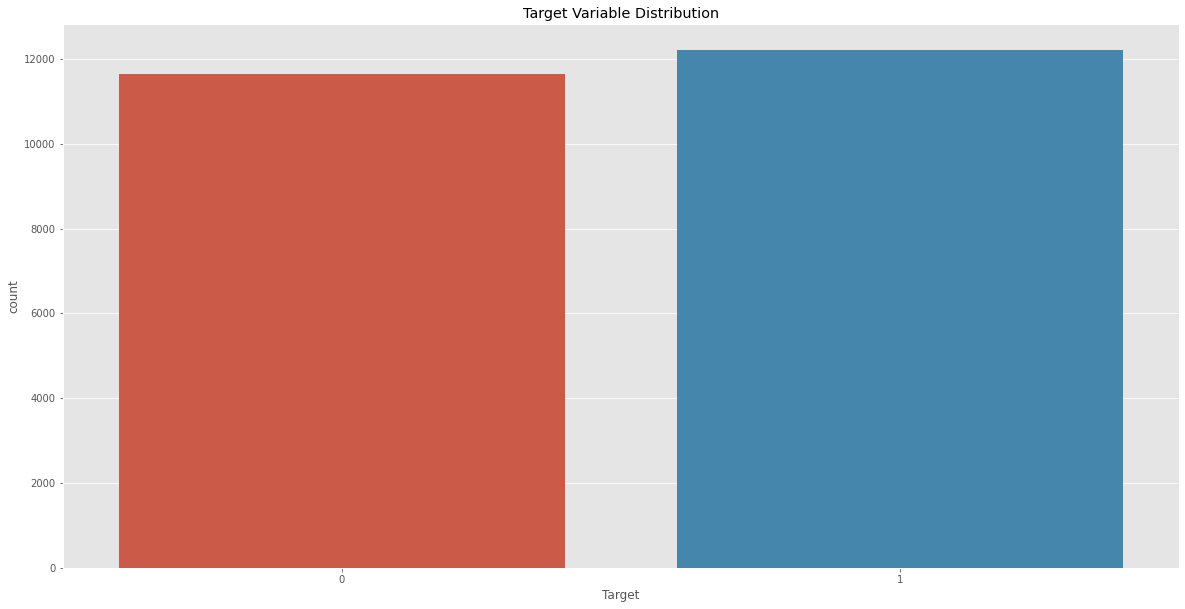

In [ ]:
plt.figure()
sns.countplot(x='Target', data=df)
plt.title('Target Variable Distribution')
plt.show()

In [ ]:
df_corr = df.copy(deep=True)
df_corr.drop(columns='Target', inplace=True)
df_corr.drop(columns='Adj Close', inplace=True)

fig = plt.figure(figsize=(20,20), dpi = 480)
sns.heatmap(df_corr.corr(), annot = True, fmt = '.2f')

#Models

In [ ]:
def accuracy_random(y_train, y_test, debug=False):
  '''
  Given a train and test targets, it prints the accuracy the model would have
  achieved if we had just predicted the majority class in the train dataset
  Entry: y_train: train targets, y_test: test targets, debug
  Returns:
  '''
  train_mc = Counter(y_train).most_common(1)[0][0]
  if debug == True:
    print(f"The most common target class in the train dataset is {train_mc} with {dict(Counter(y_train)).get(train_mc)} / {len(y_train)}")
  num_occ = dict(Counter(y_test)).get(train_mc)
  rand_acc = num_occ / (len(y_test) * 1.0) * 100.0
  print(f"The accuracy of a model that predicts the majority class in the train dataset would be {rand_acc} %")


In [ ]:
def predict_RandomForest(df, debug=False):
  if debug == True:
    X, y = extract_features_target(df, True)
  else:
    X, y = extract_features_target(df)
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
  accuracy_random(y_train, y_test, debug)

  rf = RandomForestClassifier(n_estimators=1000, max_depth=15)
  rf.fit(X_train, y_train)
  print("\n\t Random Forest Results \t")
  y_test_preds = print_accuracy(rf, X_train, X_test, y_train, y_test)
  print_precision(rf, X_train, X_test, y_train, y_test)
  cm = confusion_matrix(y_test, y_test_preds)
  s = sns.heatmap(cm, annot=True)
  s.set(xlabel='Predicted', ylabel='True')

  
  return y_test_preds, rf

In [ ]:
def predict_SVM(df, debug=False):
  if debug == True:
    X, y = extract_features_target(df, True)
  else:
    X, y = extract_features_target(df)
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
  accuracy_random(y_train, y_test, debug)

  sv = SVC()
  sv.fit(X_train, y_train)
  print("\n\t SVM Results \t")
  y_test_preds = print_accuracy(sv, X_train, X_test, y_train, y_test)
  print_precision(sv, X_train, X_test, y_train, y_test)
  cm = confusion_matrix(y_test, y_test_preds)
  s = sns.heatmap(cm, annot=True)
  s.set(xlabel='Predicted', ylabel='True')
  
  return y_test_preds, sv

In [ ]:
from sklearn.model_selection import GridSearchCV

def predict_MLP(df, debug=False):
  if debug == True:
    X, y = extract_features_target(df, True)
  else:
    X, y = extract_features_target(df)
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
  accuracy_random(y_train, y_test, debug)

  parameter_space = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (10,50), (50,50), (100,50), (50,50,50), (50,100,50),],
    'activation': ['tanh','relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
  }

  mlp = MLPClassifier(max_iter = 500)
  mlp = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=[(slice(None), slice(None))], scoring='accuracy', verbose=10)
  mlp.fit(X_train, y_train)

  if debug == True:
    print(mlp.best_params_)

  print("\n\t Multi Layer Perceptron Results \t")
  y_test_preds = print_accuracy(mlp, X_train, X_test, y_train, y_test)
  print_precision(mlp, X_train, X_test, y_train, y_test)
  cm = confusion_matrix(y_test, y_test_preds)
  s = sns.heatmap(cm, annot=True)
  s.set(xlabel='Predicted', ylabel='True')
  
  return y_test_preds, mlp

The accuracy of a model that predicts the majority class in the train dataset would be 39.90941117262204 %

	 Random Forest Results 	
Train accuracy: 98.26082093725535 %
Test accuracy: 63.781244757591004 %
Train precision: 97.49500998003991 %
Test precision: 55.729166666666664 %


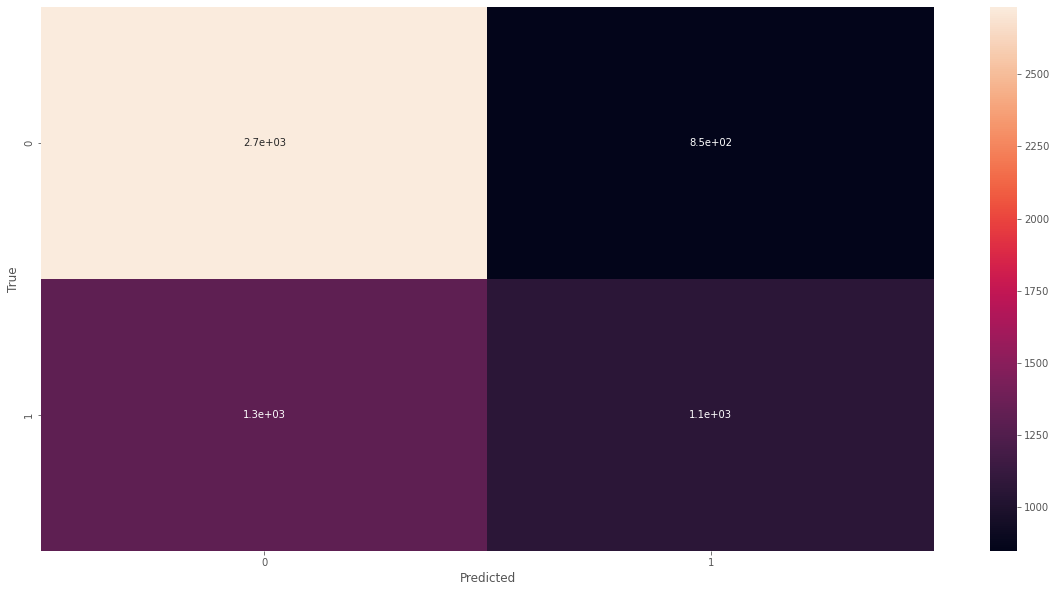

In [ ]:
predictions, model_rf = predict_RandomForest(df, False)

The accuracy of a model that predicts the majority class in the train dataset would be 39.90941117262204 %

	 SVM Results 	
Train accuracy: 55.704059948551624 %
Test accuracy: 42.84516020801879 %
Train precision: 55.783220174587775 %
Test precision: 40.25777103866566 %


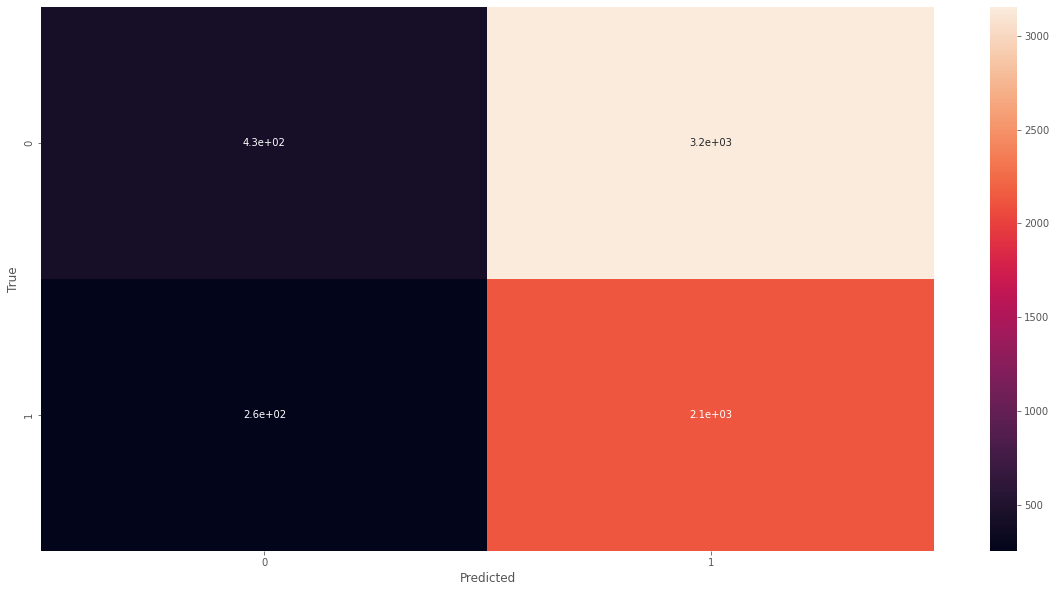

In [ ]:
predictions_svm, model_svm = predict_SVM(df, False)

The dataset has 29 features.
The most common target class in the train dataset is 1 with 9829 / 17882
The accuracy of a model that predicts the majority class in the train dataset would be 39.90941117262204 %
Fitting 1 folds for each of 16 candidates, totalling 16 fits
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}

	 Multi Layer Perceptron Results 	
Train accuracy: 82.47399619729336 %
Test accuracy: 54.97399765140077 %
Train precision: 84.8952361096633 %
Test precision: 43.65904365904366 %


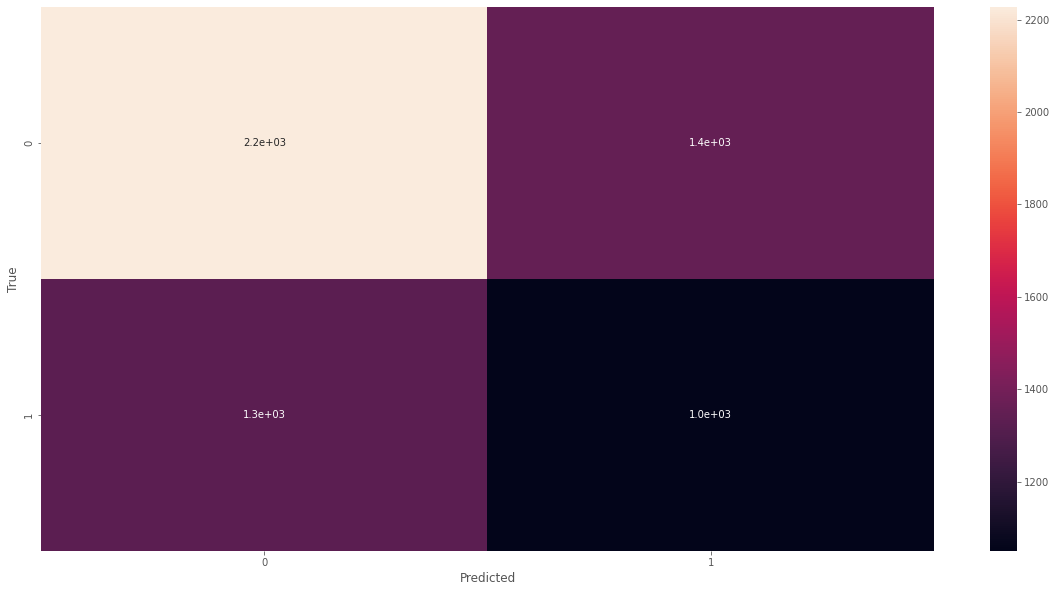

In [ ]:
predictions_mlp, model_mlp = predict_MLP(df, True)


# Backtesting

In [ ]:
def fetch_sp500(date_start, date_end, ready=False):
  headers = {
      'User-Agent': 'Mozilla/5.0'
  }

  url = "https://query1.finance.yahoo.com/v7/finance/download/^GSPC"
  x = int(date.strptime(date_start, '%Y-%m-%d').strftime("%s"))
  y = int(date.strptime(date_end, '%Y-%m-%d').strftime("%s"))
  url += "?period1=" + str(x) + "&period2=" + str(y) + \
      "&interval=1d&events=history&includeAdjustedClose=true"

  r = requests.get(url, headers=headers)
  pds = pd.read_csv(io.StringIO(r.text), index_col=0, parse_dates=True)
  if ready == True:
    return pds['Close'].values.reshape(-1,1)
  else:
    return pds

In [ ]:
def get_sp500_ret(df):
  start = df.index[0]
  end = df.index[-1]
  sp500 = fetch_sp500(start, end, True)
  return ((sp500[-1]-sp500[0])/sp500[0]*100.0), start, end

In [ ]:
def print_backtest(n_trades, acc_ret, n_succ_trades, invested, df):
  sp500, start, end = get_sp500_ret(df)
  print(f"\t Backtest Results {start} - {end} \t")
  print("=================================================================")
  print(f"Invested: {invested}$")
  print(f"Return : {acc_ret}$")
  print(f"Return (%): {acc_ret/invested * 100.0}%")
  print(f"Number of Trades: {n_trades}")
  print(f"S&P500 Return: {sp500[0]}")
  print(f"alpha: {acc_ret / invested * 100.0 - sp500[0]}%")
  print("=================================================================")


In [ ]:
def perform_backtest(model, X, df):  
  predictions = model.predict(X).tolist()
  df['Predicted'] = predictions
  df['Return'] = np.where(
      df['Predicted'] == 1, 
      df['Adj Close 1y'] - df['Adj Close'],
      0)
  n_trades = df['Predicted'].sum()
  acc_ret = df['Return'].sum()
  n_succ_trades = df['Return'].gt(0.0).sum()
  invested = df.loc[df['Predicted'] == 1, 'Adj Close'].sum()
  return n_trades, acc_ret, n_succ_trades, invested

In [ ]:
def backtest(model, df_test, percentage):
  df = df_test.tail(round(len(df_test)*percentage))
  df.sort_index(axis = 0, inplace=True)

  df['Adj Close 1y'] = df['Adj Close'] * (1 + df['Yearly Change (%)'] / 100.0)
  df.drop(columns='Yearly Change (%)', inplace=True)
  df_aux = df.drop(columns='Adj Close 1y')
  X,_ = extract_features_target(df_aux)

  n_trades, acc_ret, n_succ_trades, invested = perform_backtest(model, X, df)
  print_backtest( n_trades, acc_ret, n_succ_trades, invested, df)

In [ ]:
df = pd.read_csv('sp500_data.csv', index_col='Date')
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df.fillna(0, inplace=True)
EXPECTED_RETURN = 12.5
df['Target'] = (df['Yearly Change (%)'] > EXPECTED_RETURN).astype(int)
df.sort_index(axis = 0, inplace=True)

## Backtesting for RandomForest

In [ ]:
for percentage in [0.1, 0.125, 0.175, 0.25]:
  backtest(model_rf, df, percentage)

	 Backtest Results 2021-06-30 - 2022-07-31 	
Invested: 92544.83974699999$
Return : -1828.6794839999998$
Return (%): -1.9759929229973945%
Number of Trades: 555
S&P500 Return: -3.8908658755090064
alpha: 1.914872952511612%
	 Backtest Results 2021-01-31 - 2022-07-31 	
Invested: 116549.42799$
Return : 887.4776829999989$
Return (%): 0.7614603506043334%
Number of Trades: 714
S&P500 Return: 9.444704411243839
alpha: -8.683244060639506%
	 Backtest Results 2020-06-30 - 2022-07-31 	
Invested: 169030.095405$
Return : 21172.781533999998$
Return (%): 12.526042467922368%
Number of Trades: 1184
S&P500 Return: 33.22269810382733
alpha: -20.69665563590496%
	 Backtest Results 2019-07-31 - 2022-07-31 	
Invested: 243087.63549299998$
Return : 57755.913466$
Return (%): 23.75929707361161%
Number of Trades: 1888
S&P500 Return: 38.5826707044647
alpha: -14.823373630853087%


##Backtesting for SVM

In [ ]:
for percentage in [0.1, 0.125, 0.175, 0.25]:
  backtest(model_svm, df, percentage)

	 Backtest Results 2021-06-30 - 2022-07-31 	
Invested: 380310.051719$
Return : -8635.827985$
Return (%): -2.2707335622516656%
Number of Trades: 2087
S&P500 Return: -3.8908658755090064
alpha: 1.6201323132573409%
	 Backtest Results 2021-01-31 - 2022-07-31 	
Invested: 469687.88907100004$
Return : -1401.8583680000002$
Return (%): -0.29846593889673173%
Number of Trades: 2612
S&P500 Return: 9.444704411243839
alpha: -9.74317035014057%
	 Backtest Results 2020-06-30 - 2022-07-31 	
Invested: 621523.5964560001$
Return : 48228.946328$
Return (%): 7.759793289105524%
Number of Trades: 3669
S&P500 Return: 33.22269810382733
alpha: -25.462904814721803%
	 Backtest Results 2019-07-31 - 2022-07-31 	
Invested: 818744.007178$
Return : 112069.814141$
Return (%): 13.68801642008664%
Number of Trades: 5276
S&P500 Return: 38.5826707044647
alpha: -24.894654284378056%


##Backtesting for MLP

In [ ]:
for percentage in [0.1, 0.125, 0.175, 0.25]:
  backtest(model_mlp, df, percentage)

	 Backtest Results 2021-06-30 - 2022-07-31 	
Invested: 180036.274693$
Return : -3717.287507999999$
Return (%): -2.064743626993372%
Number of Trades: 926
S&P500 Return: -3.8908658755090064
alpha: 1.8261222485156345%
	 Backtest Results 2021-01-31 - 2022-07-31 	
Invested: 217125.689866$
Return : 252.97184400000128$
Return (%): 0.11650940252907148%
Number of Trades: 1148
S&P500 Return: 9.444704411243839
alpha: -9.328195008714767%
	 Backtest Results 2020-06-30 - 2022-07-31 	
Invested: 299286.826675$
Return : 27140.233212$
Return (%): 9.0683019742369%
Number of Trades: 1648
S&P500 Return: 33.22269810382733
alpha: -24.154396129590424%
	 Backtest Results 2019-07-31 - 2022-07-31 	
Invested: 393539.078936$
Return : 59347.67657700001$
Return (%): 15.080504009273128%
Number of Trades: 2405
S&P500 Return: 38.5826707044647
alpha: -23.50216669519157%
